In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np


from tokenizers import Tokenizer
from tokenizers.models import BPE   
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.metrics import confusion_matrix

from model import ModelArgs, TransformerForSequenceClassification


import os

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [2]:
def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)

In [3]:
df = pd.read_csv("../data/data_with_scaled_grades.csv")
df = df[["essay", "scaled_grade"]]
def let_to_num(row):
    k = {"F": 0, "D": 1, "C": 2, "B": 3, "A": 4}
    return k[row]


df["num_grade"] = df["scaled_grade"].apply(let_to_num)


dfl1 = pd.read_csv('../data/lexical_features_5_07.csv')
dfl1 = dfl1[['essay_id','num_chars_essay', 'num_puncts_essay', 'num_words_essay',
       'num_unique_words_essay', 'num_correct_words', 'num_noun', 'num_adj']]

dfl2 = pd.read_csv('../data/lexical_avg_features_5_12.csv')
dfl2 = dfl2[['essay_id','avg_num_chars_word',
       'avg_num_chars_sent', 'avg_num_puncts_word', 'avg_num_puncts_sent',
       'avg_num_words_sent', 'avg_num_unique_words_essay']]

dfl = dfl1.join(dfl2,lsuffix='l').drop(columns=['essay_idl'])


dfl = (dfl - dfl.mean()) / dfl.std() # normalize

df = pd.concat([df,dfl],axis=1)

tr = round(len(df) * 0.8)
val = round(len(df) * 0.1)

df_train = df[0:tr]
df_val = df[tr : tr + val]
df_test = df[tr + val :]

In [4]:
if not os.path.exists('tokenizer.json'):
    x = df["essay"]

    trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],vocab_size=30000)

    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

    tokenizer.pre_tokenizer = Whitespace()

    tokenizer.train_from_iterator(x, trainer=trainer)


    tokenizer.save("tokenizer.json")
else:
    tokenizer = Tokenizer.from_file('tokenizer.json')
    

In [5]:
class EssayDataset(Dataset):
    def __init__(self, essay_df, tokenizer):

        self.row_dicts = []

        for i,row in essay_df.iterrows():      
            self.row_dicts.append(row.to_dict())

        self.tokenizer = tokenizer

        

    def __len__(self):
        return len(self.row_dicts)

    def __getitem__(self, index):

        row = self.row_dicts[index]

        encoded_essay = self.tokenizer.encode(row['essay'])
        score = row['num_grade']
        num_chars = row['num_chars_essay']
        num_puncts = row['num_puncts_essay']
        num_words = row['num_words_essay']
        num_unique_w = row['num_unique_words_essay']
        num_correct = row['num_correct_words']
        num_noun = row['num_noun']
        num_adj = row['num_adj']

        input_ids = torch.tensor(encoded_essay.ids, dtype=torch.long)#.unsqueeze(0)

        context = torch.tensor([num_chars,num_puncts,num_words,num_unique_w,num_correct,num_noun,num_adj],dtype=torch.float)

    

        return {
            'ids':input_ids,
            'context':context,
            'label':torch.tensor([score], dtype=torch.long).squeeze(0),
        }

    def num_classes(self):
        return 5 # this is bad
 
    def __repr__(self) -> str:
        return f"Dataset with {len(self)} essays"


ds_train = EssayDataset(df_train, tokenizer)
ds_val = EssayDataset(df_val, tokenizer)

In [7]:
config = ModelArgs(
   dim=768,
   n_layers=40,
   n_heads=32,
   vocab_size=tokenizer.get_vocab_size(),
    n_classes=ds_train.num_classes(),
    context_size=len(ds_train[0]['context'])
)
model = TransformerForSequenceClassification(config)
print(f"{model.params():,}")


#state_dict = torch.load('weights/model_epoch_5.pt')
#model.load_state_dict(state_dict)
#del state_dict

model = model.to(device)


306,227,717


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)



train_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True, drop_last=True)
val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True, drop_last=True)


In [35]:
start_epoch = 1
end_epoch = 15
batch_losses = []
val_losses = []
val_accuracies = []
for epoch in range(start_epoch,end_epoch):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):
        tokens = batch['ids'].to(device)
        context = batch['context'].to(device)
        labels = batch['label'].to(device)
        
        out = model(tokens,context)
        loss = loss_fn(out, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(running_loss /( 1 if batch_idx == 0 else batch_idx))

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss /( 1 if batch_idx == 0 else batch_idx))
        
       
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    preds_for_cm = []
    labels_for_cm = []

    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating Epoch {epoch:02d}")
        for idx,batch in enumerate(val_iterator):
            tokens = batch['ids'].to(device)
            context = batch['context'].to(device)
            labels = batch['label'].to(device)

            out = model(tokens,context)
            loss = loss_fn(out,labels)

            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            preds_for_cm.append(preds.cpu().numpy())
            labels_for_cm.append(labels.cpu().numpy())
            

            val_losses.append(loss.item())
            val_accuracies.append(val_correct / val_total)
            

    scheduler.step(val_loss)


    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total

    torch.save(model.state_dict(), os.path.join('weights', f'model_epoch_{epoch+1}.pt'))

    print(
        f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {running_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )
    print('Val QWKS:', quadratic_weighted_kappa(confusion_matrix(labels_for_cm,preds_for_cm)))
    


Validating Epoch 01:   0%|          | 0/1298 [00:00<?, ?it/s]


Epoch [2/15], Train Loss: 0.0009, Val Loss: 0.0006, Val Accuracy: 0.0000
Val QWKS: 0.0


Validating Epoch 02:   0%|          | 0/1298 [00:00<?, ?it/s]


Epoch [3/15], Train Loss: 0.0006, Val Loss: 0.0004, Val Accuracy: 1.0000


ZeroDivisionError: division by zero

In [10]:
ds_test = EssayDataset(df_test, tokenizer)

In [11]:
preds = []
labels = []
with torch.no_grad():
   for x in tqdm(ds_test):  # Correct placement of tqdm
        tokens = x['ids'].unsqueeze(0).to(device)
        context =x['context'].to(device)
        label = x['label']

        out = model(tokens,context)
        pred = torch.argmax(out)

        preds.append(pred.cpu())
        labels.append(label)


preds = torch.stack(preds).cpu().numpy()
labels = torch.stack(labels).squeeze().numpy()


100%|██████████| 1297/1297 [01:03<00:00, 20.48it/s]


In [12]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels,preds)

In [13]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=["f","d","c",'b','a'])

print(report)

              precision    recall  f1-score   support

           f       0.00      0.00      0.00        53
           d       0.42      0.12      0.18       387
           c       0.29      0.72      0.41       338
           b       0.47      0.34      0.39       398
           a       0.15      0.07      0.10       121

    accuracy                           0.33      1297
   macro avg       0.27      0.25      0.22      1297
weighted avg       0.36      0.33      0.29      1297



/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


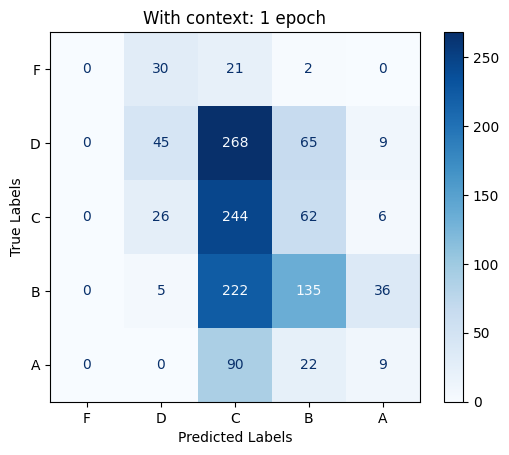

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["F", "D", "C", "B", "A"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('With context: 1 epoch')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [15]:
def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)

quadratic_weighted_kappa(conf_matrix)

0.26014558350088846